In [47]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.tseries.offsets import BDay
import time
import calendar as cal
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
# from statsmodels.stats.weightstats import ttest_ind
# import statsmodels.discrete.discrete_model as dm
import seaborn as sns
# from sklearn.base import TransformerMixin
# from sklearn.pipeline import make_union, make_pipeline
# from sklearn.tree import DecisionTreeClassifier as DTC
# from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier  #, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, matthews_corrcoef
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
# from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from talib import RSI, OBV, MACD, EMA
import quandl

now = None
def tick():
	global now
	now = time.clock()

def tock(*s):
	global now
	assert now is not None, "Gotta tick before ya can tock!"
	if s:
		print(s[0], ':', round(time.clock() - now, 2), "seconds"),
	tick()

ftrs = [
	'YM',  # Dow e-Mini
	'ES',  # S&P 500 e-Mini
	'NQ',  # Nasdaq 100 e-Mini
	'ER',  # Russell 2000 Mini
]

In [48]:
QUANDL_API_KEY = 'ZCLSs1s9ojeHEFssKL6S'
sent = quandl.get('AAII/AAII_SENTIMENT', start_date='2002-01-03', api_key=QUANDL_API_KEY).resample('D').asfreq().interpolate().loc[lambda i: i.index.minute == 0,:]
conf = quandl.get("YALE/US_CONF_INDEX_VAL_INDIV", start_date='2001-12-01', api_key=QUANDL_API_KEY).resample('D').asfreq().interpolate().ix[sent.index]

In [49]:
QUANDL_API_KEY = 'ZCLSs1s9ojeHEFssKL6S'
qdata = quandl.get(['AAII/AAII_SENTIMENT.1','AAII/AAII_SENTIMENT.3','YALE/US_CONF_INDEX_VAL_INDIV.1','USTREASURY/LONGTERMRATES.1','USTREASURY/REALYIELD.1','ML/USTRI.1'], start_date='2002-01-03', api_key=QUANDL_API_KEY).tz_localize('US/Eastern').resample('H').interpolate(method='time').fillna(method='bfill')

,AAII/AAII_SENTIMENT - Bullish,AAII/AAII_SENTIMENT - Bearish,YALE/US_CONF_INDEX_VAL_INDIV - Index Value,USTREASURY/LONGTERMRATES - LT Composite > 10 Yrs,USTREASURY/REALYIELD - 5 YR,ML/USTRI - BAMLH0A0HYM2EY


In [7]:
d2 = pd.read_pickle('data/data2.p')

In [77]:
def macdSig(macd):
	return np.subtract(macd[0], macd[1])

def toPercent(ts):
	last = ts[-1]
	return (last-np.mean(ts))/last if last > 0. else last

def getData(panel):
	tick()
	QUANDL_API_KEY = 'ZCLSs1s9ojeHEFssKL6S'
	qdata = quandl.get(
		['AAII/AAII_SENTIMENT.1','AAII/AAII_SENTIMENT.3','YALE/US_CONF_INDEX_VAL_INDIV.1','USTREASURY/LONGTERMRATES.1','USTREASURY/REALYIELD.1','ML/USTRI.1'], start_date='2002-01-03', api_key=QUANDL_API_KEY).tz_localize('US/Eastern').resample('H').interpolate(method='time').fillna(method='bfill')
	qdata.columns = ['bull','bear','conf','tr','ty','by']
	# crucial for running fast
	ftrpanel = panel.loc[:, panel.major_axis.minute == 0, :]
	tock('pre-format')
	
	'''Runtime for full backtest from 2002: ~27 min.
	Can't think of a better way than to use nested loops
	'''
	hours = range(8, 14 + 1)
	days = range(1, 10 + 1)
	l1 = []
	# ~320 sec per loop
	for h in hours:
		l2 = []
		idx = ftrpanel.loc[:, (ftrpanel.major_axis.hour == h) & (ftrpanel.major_axis.dayofweek < 5), :].major_axis
		for d in days:
			print('-', end=' ')
			d1 = {}
			for i in idx:
				i = pd.to_datetime(i)
				prd = ftrpanel.loc[:, i.replace(hour=16) - BDay(d):i, :]
				prdP = prd['price']
				prdV = prd['vol']
				tp = len(prdP)
				dic = {
					'p_fwd': ftrpanel.loc['price', i + dt.timedelta(hours=2), :],
					'p_fwd_std_15min': panel.loc['price', (panel.major_axis >= i + dt.timedelta(hours=1, minutes=45))&(panel.major_axis <= i + dt.timedelta(hours=2)), :].std(),
					'p_cur': prdP.iloc[-1],
					'p_prd': prdP.iloc[0],
					'p_ema': [EMA(prdP[j].values, timeperiod=tp - 1)[-1] if not prdP[j].isnull().all() else np.NaN for j in prdP.columns],
					'p_ema2': [EMA(prdP[j].values, timeperiod=tp / 2)[-1] if not prdP[j].isnull().all() else np.NaN for j in prdP.columns],
					# -------------------
					# 'p_avg': prdP.mean(),
					# 'prd_vwap': toPercent(prdP*prdV).sum()/prdV.sum(),
					# 'p_med': prdP.median(),
					# 'p_std': prdP.std(),
					# 'p_skw': prdP.skew(),
					# 'p_krt': prdP.kurt(),
					# -------------------
					# 'v_cur': prdV.iloc[-1],
					'v_ema': [EMA(prdV[j].values, timeperiod=tp - 1)[-1] if not prdV[j].isnull().all() else np.NaN for j in prdV.columns],
					'v_ema2': [EMA(prdV[j].values, timeperiod=tp / 2)[-1] if not prdV[j].isnull().all() else np.NaN for j in prdV.columns],
					# 'v_med': prdV.median(),
					# 'v_std': prdV.std(),
					# 'v_skw': prdV.skew(),
					# 'v_krt': prdV.kurt(),
					# -------------------
					'rsi': [RSI(prdP[j].values, timeperiod=tp-1)[-1] if not prdP[j].isnull().all() else np.NaN for j in prdP.columns],
					'obv': [toPercent(OBV(prdP[j].values, prdV[j].values)) if not (prdP[j].isnull().all()) | (prdV[j].isnull().all()) else np.NaN for j in prdP.columns],
					'macd': [macdSig(MACD(prdP[j].values, slowperiod=tp/2, fastperiod=tp/3, signalperiod=tp/5))[-1] if not prdP[j].isnull().all() else np.NaN for j in prdP.columns],
					# 'p_2ma': prdP.iloc[-2:].mean(),
					# 'v_2ma': prdV.iloc[-2:].mean(),
					'bull': qdata.loc[i, 'bull'],
					'bear': qdata.loc[i, 'bear'],
					'tr': qdata.loc[i, 'tr'],
					'ty': qdata.loc[i, 'ty'],
					'by': qdata.loc[i, 'by'],
					'conf': qdata.loc[i, 'conf'],
				}
				d1[i.normalize()] = pd.DataFrame.from_dict(dic)
			l2.append(pd.Panel.from_dict(d1).swapaxes(0, 1, copy=False))
		l1.append(pd.concat(l2, keys=days, axis=2))
		tock(h)
	data = pd.concat(l1, keys=hours)
	return data

data = getData(pd.read_pickle('PycharmProjects/Nadex Binaries/data/panel_raw_hr.p').iloc[:,:,:])

pre-format : 2.3 seconds
- 

- 

- 

- 

- 

- 

- 

- 

- 

- 

8 : 331.12 seconds
- 

- 

- 

- 

- 

- 

- 

- 

- 

- 

9 : 323.5 seconds
- 

- 

- 

- 

- 

- 

- 

- 

- 

- 

10 : 330.71 seconds
- 

- 

- 

- 

- 

- 

- 

- 

- 

- 

11 : 322.67 seconds
- 

- 

- 

- 

- 

- 

- 

- 

- 

- 

12 : 328.72 seconds
- 

- 

- 

- 

- 

- 

- 

- 

- 

- 

13 : 334.17 seconds
- 

- 

- 

- 

- 

- 

- 

- 

- 

- 

14 : 327.05 seconds


In [80]:
tick()
d2 = data.to_frame(filter_observations=False)
d2 = d2.unstack().stack(level=(0,1), dropna=False)#.dropna()
d2.index.set_names(['date', 'lkbk', 'time', 'mkt'],inplace=True)
d2.reset_index(inplace=True)
d2['wkdy'] = d2['date'].map(lambda i: i.weekday())
d2['wk#'] = d2['date'].map(lambda i: int(round(i.day-1)/7))
d2['prd_rtn'] = (d2['p_cur'] - d2['p_prd'])/d2['p_cur']
# d2['p_avg'] = (d2['p_cur'] - d2['p_avg'])/d2['p_cur']
# # d2['p_med'] = (d2['p_cur'] - d2['p_med'])/d2['p_cur']
# d2['p_2ma'] = (d2['p_cur'] - d2['p_2ma'])/d2['p_cur']
# # ------------------
# d2['v_avg'] = (d2['v_cur'] - d2['v_avg'])/d2['v_cur']
# # d2['v_med'] = (d2['v_cur'] - d2['v_med'])/d2['v_cur']
d2['fwd_rtn'] = (d2['p_fwd'] - d2['p_cur'])/d2['p_cur']
d2['s'] = (d2['prd_rtn'] > 0.0).astype(int)
d2['w'] = (d2['fwd_rtn'] >= 0.0).astype(int)
# d2.replace(to_replace=[np.NaN, np.Inf, -np.Inf], value=0.0, inplace=True)

d2.set_index('date', inplace=True)

tock()

In [97]:
d3

,lkbk,time,mkt,bear,bull,by,conf,macd,obv,p_cur,...,tr,ty,v_ema,v_ema2,wkdy,wk#,prd_rtn,fwd_rtn,s,w
date,,,,,,,,,,,,,,,,,,,,,
2002-01-03 00:00:00-05:00,1,8,1,0.243200,0.512852,12.676667,62.26,NaN,0.0,1107.819000,...,5.803333,1.7500,0.0,0.0,3,0,NaN,0.003893,0,1
2002-01-03 00:00:00-05:00,1,8,2,0.243200,0.512852,12.676667,62.26,NaN,0.0,1819.507000,...,5.803333,1.7500,0.0,0.0,3,0,NaN,0.011040,0,1
2002-01-03 00:00:00-05:00,1,9,1,0.243050,0.513071,12.675000,62.26,NaN,0.0,1103.505000,...,5.805000,1.7500,0.0,0.0,3,0,NaN,0.008903,0,1
2002-01-03 00:00:00-05:00,1,9,2,0.243050,0.513071,12.675000,62.26,NaN,0.0,1811.138000,...,5.805000,1.7500,0.0,0.0,3,0,NaN,0.023105,0,1
2002-01-03 00:00:00-05:00,1,10,1,0.242900,0.513290,12.673333,62.26,NaN,0.0,1112.132000,...,5.806667,1.7500,0.0,0.0,3,0,NaN,0.000216,0,1
2002-01-03 00:00:00-05:00,1,10,2,0.242900,0.513290,12.673333,62.26,NaN,0.0,1839.594000,...,5.806667,1.7500,0.0,0.0,3,0,NaN,0.007583,0,1
2002-01-03 00:00:00-05:00,1,10,3,0.242900,0.513290,12.673333,62.26,NaN,0.0,459.145500,...,5.806667,1.7500,0.0,0.0,3,0,NaN,-0.006184,0,0
2002-01-03 00:00:00-05:00,1,11,1,0.242750,0.513510,12.671667,62.26,0.483550,0.0,1113.330000,...,5.808333,1.7500,0.0,0.0,3,0,NaN,-0.000860,0,0
2002-01-03 00:00:00-05:00,1,11,2,0.242750,0.513510,12.671667,62.26,2.268086,0.0,1852.985000,...,5.808333,1.7500,0.0,0.0,3,0,NaN,0.001806,0,1


In [438]:
d2['diff'] = (2*d2['p_cur']-d2['p_ema']-d2['p_ema2'])/d2['p_cur']
d2['v_diff'] = (2 * d2['v_ema2'] - d2['v_ema'] - d2['v_ema2']) / d2['v_ema2']
d2['bull-bear'] = d2['bull'] - d2['bear']

cols = [
	# 'bear',
	# 'bull',
	'bull-bear',
	'w',
	'by',
	'conf',
	'macd',
	'obv',
	# 'p_cur',
	# 'p_ema',
	# 'p_ema2',
	'diff',
	# 'p_fwd_std_15min',
	# 'p_prd',
	'rsi',
	'tr',
	'ty',
	# 'v_ema',
	# 'v_ema2',
	'v_diff',
	'prd_rtn',
	'fwd_rtn'
]

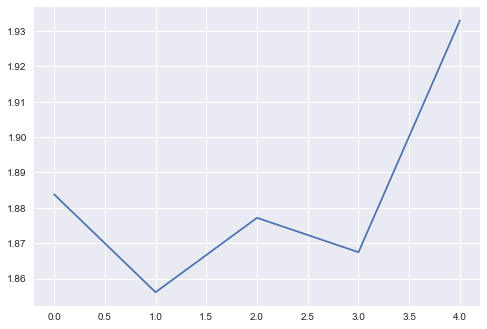

In [51]:
x = d2['wkdy'].value_counts()
x2 = d2[(d2['w'] == 1)]['wkdy'].value_counts()
plt.plot(x.sort_index() / x2.sort_index())
# plt.plot(x2.sort_index())
plt.show()

In [79]:
# print(len(d2[d2==0.]))
# print(len(d2[d2['prd_rtn']==0.]))
# plt.hist(d2[d2['prd_rtn'] == 0.].index, bins=50)
# plt.show()
t = d2['2016']
t[t['prd_rtn'] == 0.].iloc[:,[1,0]]

,time,lkbk,prd_rtn
date,,,
2016-01-05 00:00:00-05:00,14,1,0.0
2016-01-11 00:00:00-05:00,13,1,0.0
2016-01-13 00:00:00-05:00,11,1,0.0
2016-01-27 00:00:00-05:00,9,3,0.0
2016-01-28 00:00:00-05:00,13,7,0.0
2016-02-03 00:00:00-05:00,13,10,0.0
2016-02-05 00:00:00-05:00,8,1,0.0
2016-02-05 00:00:00-05:00,10,2,0.0
2016-02-08 00:00:00-05:00,11,10,0.0


In [445]:
x = d2[
	(d2.mkt == 0) &
	(d2.lkbk == 5) &
	(d2.wkdy == 4) &
	(d2['wk#'] == 1) &
	(d2.time == 14)
	].iloc[4:]
x = x[x['prd_rtn'] > -.25]
g = sns.PairGrid(x[cols].replace(to_replace=np.NaN, value=x.mean()), hue='w', vars=[c for c in cols if c != 'w']).map_lower(plt.scatter).map_upper(sns.regplot).map_diag(plt.hist, bins=30).add_legend()
plt.savefig('more.png')

In [270]:
import statsmodels
X = sm.add_constant(x[[c for c in x.columns if c != 'fwd_rtn']].dropna().values)
results = statsmodels.regression.linear_model.OLS(x['fwd_rtn'], X).fit()
results.summary()

<table class="simpletable">
<caption>OLS Regression Results</caption>
<tr>
  <th>Dep. Variable:</th>         <td>fwd_rtn</td>     <th>  R-squared:         </th> <td>   0.056</td>
</tr>
<tr>
  <th>Model:</th>                   <td>OLS</td>       <th>  Adj. R-squared:    </th> <td>  -0.020</td>
</tr>
<tr>
  <th>Method:</th>             <td>Least Squares</td>  <th>  F-statistic:       </th> <td>  0.7399</td>
</tr>
<tr>
  <th>Date:</th>             <td>Tue, 02 May 2017</td> <th>  Prob (F-statistic):</th>  <td> 0.639</td> 
</tr>
<tr>
  <th>Time:</th>                 <td>18:44:50</td>     <th>  Log-Likelihood:    </th> <td>  435.32</td>
</tr>
<tr>
  <th>No. Observations:</th>      <td>    96</td>      <th>  AIC:               </th> <td>  -854.6</td>
</tr>
<tr>
  <th>Df Residuals:</th>          <td>    88</td>      <th>  BIC:               </th> <td>  -834.1</td>
</tr>
<tr>
  <th>Df Model:</th>              <td>     7</td>      <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th>Covariance Type:</th>      <td>nonrobust</td>    <th>                     </th>     <td> </td>   
</tr>
</table>
<table class="simpletable">
<tr>
    <td></td>       <th>coef</th>     <th>std err</th>      <th>t</th>      <th>P>|t|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>const</th> <td>    0.0013</td> <td>    0.003</td> <td>    0.459</td> <td> 0.647</td> <td>   -0.004</td> <td>    0.007</td>
</tr>
<tr>
  <th>x1</th>    <td>   -0.0105</td> <td>    0.023</td> <td>   -0.463</td> <td> 0.644</td> <td>   -0.055</td> <td>    0.034</td>
</tr>
<tr>
  <th>x2</th>    <td>   -0.0020</td> <td>    0.005</td> <td>   -0.401</td> <td> 0.690</td> <td>   -0.012</td> <td>    0.008</td>
</tr>
<tr>
  <th>x3</th>    <td>   -0.0016</td> <td>    0.005</td> <td>   -0.319</td> <td> 0.751</td> <td>   -0.012</td> <td>    0.008</td>
</tr>
<tr>
  <th>x4</th>    <td>   -0.0004</td> <td>    0.001</td> <td>   -0.292</td> <td> 0.771</td> <td>   -0.003</td> <td>    0.002</td>
</tr>
<tr>
  <th>x5</th>    <td> 4.708e-05</td> <td> 4.63e-05</td> <td>    1.018</td> <td> 0.312</td> <td>-4.48e-05</td> <td>    0.000</td>
</tr>
<tr>
  <th>x6</th>    <td>   -0.0006</td> <td>    0.000</td> <td>   -1.490</td> <td> 0.140</td> <td>   -0.001</td> <td>    0.000</td>
</tr>
<tr>
  <th>x7</th>    <td>    0.0001</td> <td>    0.000</td> <td>    0.850</td> <td> 0.398</td> <td>   -0.000</td> <td>    0.000</td>
</tr>
<tr>
  <th>x8</th>    <td>   -0.0104</td> <td>    0.082</td> <td>   -0.128</td> <td> 0.899</td> <td>   -0.173</td> <td>    0.152</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Omnibus:</th>       <td>30.222</td> <th>  Durbin-Watson:     </th> <td>   1.993</td>
</tr>
<tr>
  <th>Prob(Omnibus):</th> <td> 0.000</td> <th>  Jarque-Bera (JB):  </th> <td> 104.907</td>
</tr>
<tr>
  <th>Skew:</th>          <td>-0.953</td> <th>  Prob(JB):          </th> <td>1.66e-23</td>
</tr>
<tr>
  <th>Kurtosis:</th>      <td> 7.754</td> <th>  Cond. No.          </th> <td>2.39e+18</td>
</tr>
</table>

In [276]:
g = sns.PairGrid(x)
g.map_offdiag(plt.scatter, c=x.index)
plt.savefig('xxx')
plt.show()

TypeError: __init__() got an unexpected keyword argument 'c'

In [219]:
numcols = [
 # 'macd',
 # 'obv',
 # 'p_2ma',
 # 'p_avg',
 # 'p_krt',
 # 'p_med',
 # 'p_skw',
 # 'p_std',
 # 'rsi',
 # 'v_avg',
 # 'v_cur',
 # 'v_krt',
 # 'v_med',
 # 'v_skw',
 # 'v_std',
 'prd_rtn',
]

In [155]:
def summarize(df):
    s = df['s']
    w = df['w']
    return pd.Series({
        'z': proportions_ztest(sum(s&w).sum(), sum(s), value=0.5, alternative='two-sided')[0] if sum(s) else np.NaN,
        'confusion_matrix': confusion_matrix(w,s),
        'f1': f1_score(w,s),
        'accuracy': accuracy_score(w,s),
        'precision': precision_score(w,s),
        'matthews': matthews_corrcoef(w,s)
    })

tick()
summ = d2.groupby(['mkt', 'lkbk', 'wkdy', 'wk#', 'time']).apply(summarize)
summ['abs z'] = np.abs(summ['z'])
summ['NOBS'] = summ['confusion_matrix'].map(lambda i: sum(i.flatten()))
tock('summarize')

summarize : 27.64 seconds


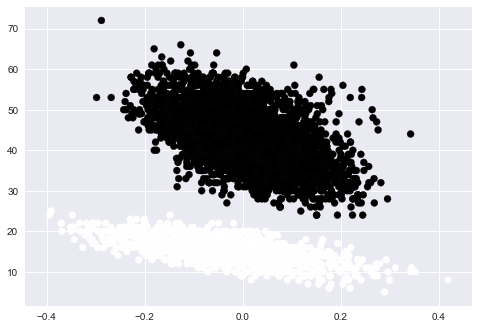

In [184]:
# summ.sort_values('accuracy', ascending=False)#.reset_index().drop_duplicates(['wkdy','wk#']).set_index(['mkt','lkbk','wkdy','wk#','time'])
# sns.pairplot(summ)
# plt.savefig('pairplot.png')
plt.cla()
plt.scatter(summ['matthews'], summ['confusion_matrix'].map(lambda i: i[1][0]), c=summ['NOBS'])
plt.show()

In [ ]:
# summ.loc[(slice(None),slice(None),1,2,slice(None)),:].sort_values('z', ascending=False)
# sns.pairplot(summ.drop_duplicates(['wkdy','wk#','mkt']), hue='mkt', vars=['F1','acc','matt','prec','z'], size=3, diag_kind="kde");
# g = sns.PairGrid(summ.drop_duplicates(['wkdy','wk#','mkt']), hue='mkt', vars=['F1','acc','matt','prec','z'])
# g = g.map_upper(plt.scatter)
# g = g.map_lower(sns.kdeplot)
# g = g.map_diag(sns.kdeplot, lw=3)
# g = g.add_legend()
# sns.rugplot(d2[
#     (d2.mkt==2)&
#     (d2.lkbk==1)&
#     (d2.wkdy==3)&
#     (d2['wk#']==4)&
#     (d2.time==8)&
#     (d2.prd_rtn>0)
# ]['fwd_rtn'], height=1)
xx = d2[
    (d2.mkt==0)&
    (d2.lkbk==5)&
    (d2.wkdy==4)&
    (d2['wk#']==1)&
    (d2.time==14)
#     &(d2.fwd_rtn<300)
]
g = sns.PairGrid(xx, vars=numcols+['fwd_rtn'])
g = g.map_upper(sns.regplot)
g = g.map_lower(sns.kdeplot)
g = g.map_diag(plt.hist)
# g = g.add_legend()

In [220]:
x = d2[
	(d2.mkt == 0) &
	(d2.lkbk == 5) &
	(d2.wkdy == 4) &
	(d2['wk#'] == 1) &
	(d2.time == 14)
	]
	
catcols = [
	# 'mkt',
	# 'time',
	# 'lkbk',
	# 'wkdy',
	# 'wk#',
]

split = dt.datetime(2017, 1, 1)

man_results = summarize(x[x.index >= split])

x1 = x.loc[x.index < split, catcols + numcols]
# y1 = (x.loc[x.index < split, 'fwd_rtn'] >= 0).astype(int)
y1 = x.loc[x.index < split, 'fwd_rtn']
x2 = x.loc[x.index >= split, catcols + numcols]
# y2 = (x.loc[x.index >= split, 'fwd_rtn'] >= 0).astype(int)
y2 = x.loc[x.index >= split, 'fwd_rtn']

# w = 1000*np.array(range(1,len(x1)+1))/float(len(x1))
tick()

ss = StandardScaler().fit(x1[numcols])
if catcols:
	oe = OneHotEncoder().fit(x1[catcols])
	x1 = np.concatenate((oe.transform(x1[catcols]).toarray(), ss.transform(x1[numcols])), axis=1)
	x2 = np.concatenate((oe.transform(x2[catcols]).toarray(), ss.transform(x2[numcols])), axis=1)
else:
	x1 = ss.transform(x1[numcols])
	x2 = ss.transform(x2[numcols])
#     pca = PCA(n_components=3).fit(x1)
#     x1 = pca.transform(x1)
#     x2 = pca.transform(x2)

from sklearn.linear_model import Lasso, ElasticNet
l = Lasso()
l.fit(x1, y1)
print(l.score(x2, y2))
e = ElasticNet()
e.fit(x1, y1)
print(e.score(x2, y2))


clfs = {
	'LSVC': [LinearSVC(), {
		'C': [1, 10, 100],
	}],
	# 'SVC': [SVC(), {
	# 	'C': [1, 10, 100],
	# 	'kernel': ['linear', 'rbf'],
	# 	# 'gamma': [0, 0.1, 1, 10],
	# 	'probability': [True, False]
	# }],
	'SGD': [SGDClassifier(), {
		# 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber',
		#          'epsilon_insensitive', 'squared_epsilon_insensitive'],
		# 'penalty': ['none', 'l1', 'l2', 'elasticnet'],
		'alpha': [0.0001, 0.001, 0.01],
	}],
	'RFC': [RandomForestClassifier(), {
		'n_estimators': [10, 50, 100],
		'criterion': ['gini', 'entropy'],
		'max_features': [None, 'auto'],
		'min_samples_split': [10, 50, 100],
	}],
	'KNN': [KNeighborsClassifier(), {
		'n_neighbors': [5, 10, 30],
		'weights': ['uniform', 'distance'],
		'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
		'p': [1, 2, 3],
	}],
	'GBC': [GradientBoostingClassifier(), {
		'loss': ['deviance', 'exponential', 'deviance'],
		'learning_rate': [0.01, 0.1, 1],
		'max_depth': [2, 3, 4],
	}],
	'MLP': [MLPClassifier(), {
		'hidden_layer_sizes': [(5,2)],
		'activation': ['logistic', 'relu'],
		'solver': ['lbfgs'],
		'alpha': [1e-5],
		'learning_rate': ['constant', 'adaptive'],
	}]
}

def classify(params, x1, y1, x2, y2):
	now = time.clock()
	gscv = GridSearchCV(*params, scoring='f1').fit(x1, y1)
	t = time.clock() - now
	pred2 = gscv.predict(x2)
	return {'metrics': {
		'precision': precision_score(y2, pred2),
		'accuracy': accuracy_score(y2, pred2),
		'f1': f1_score(y2, pred2),
		'matthews': matthews_corrcoef(y2, pred2),
		'training accuracy': accuracy_score(y1, gscv.best_estimator_.predict(x1)),
	},
		'best_classifier': gscv.best_estimator_,
		'other': {
			'confusion_matrix': confusion_matrix(y2, pred2),
			'best_params': gscv.best_params_,
			'training time': t,
		},
	}

# results = {name: classify(params, x1=x1, y1=y1, x2=x2, y2=y2) for (name, params) in clfs.items()}
# metrics = pd.DataFrame([p['metrics'] for (n, p) in results.items()], index=results.keys())
# metrics = metrics.append(pd.Series(man_results[['f1', 'accuracy', 'matthews', 'precision']], name='Manual'))
# metrics.index.set_names('Classifier', inplace=True)
# metrics.reset_index(inplace=True)
# metrics = pd.melt(metrics, id_vars='Classifier', var_name='Metric')
# fig, ax = plt.subplots(nrows=1, ncols=len(results) + 1)
# for n, p in results.items():
# 	i = list(results.keys()).index(n)
# 	# plt.xlabel('pred')
# 	# plt.ylabel('true')
# 	# lab = ['N', 'P'] if i == 0 else False
# 	sns.heatmap(p['other']['confusion_matrix'], annot=True, cbar=False, square=True, ax=ax[i])
# 	ax[i].set_title(n)
# sns.heatmap(man_results['confusion_matrix'], annot=True, cbar=False, square=True, ax=ax[len(results)])
# ax[len(results)].set_title('Manual')
# plt.figure()
# sns.barplot(data=metrics, hue='Classifier', x='Metric', y='value');
# for n, p in results.items():
# 	print(n)
# 	print(pd.Series(p['other']['best_params']))
# 	print('----------------------------')
# plt.show()

-0.727672639567
-0.727672639567


/Users/Jake/anaconda/lib/python3.6/site-packages/statsmodels/stats/weightstats.py:575: RuntimeWarning: divide by zero encountered in double_scalars
  zstat = value / std_diff


In [204]:
l.coef_

array([-0., -0.,  0., -0.])

In [200]:
{(i, j['other']['training time']) for i, j in results.items()}

{('GBC', 12.397621999999956),
 ('KNN', 67.04188599999998),
 ('LSVC', 1.9319550000000163),
 ('MLP', 6.504247999999734),
 ('RFC', 34.0948070000004),
 ('SGD', 0.3502669999998034),
 ('SVC', 1858.341202)}

In [119]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, input_shape=x1.shape, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.fit(x1.reshape(1,5040,1), y1.reshape(1,5040,1), epochs=200, verbose=0)
score = model.evaluate(x1.reshape(1,5040,1), y1.reshape(1,5040,1))

/Users/Jake/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


1/1 [==============================] - 0s

/Users/Jake/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [201]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
mlp.fit(x1, y1)
pred2 = mlp.predict(x2)
accuracy_score(y2,pred2)

0.59999999999999998

In [113]:
x1.shape

(5040, 1)

In [143]:
x=d2[(d2['mkt'] == 0) & (d2['lkbk'] == 5) & (d2['time'] == 14) & (d2['wkdy'] == 4)&(d2['wk#'] == 1)].iloc[4:]
# plt.plot(x['s'].rolling(50).mean())
# plt.plot(x['w'].rolling(50).mean())
# plt.plot((x['w']&x['s']).rolling(100).mean())
# plt.legend()
# plt.show()

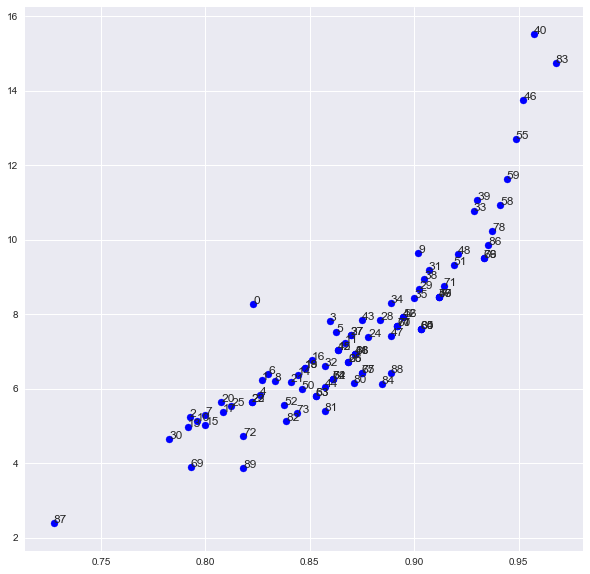

In [147]:
info = []
plt.figure(figsize=(10,10))
for i in range(90):
	sh = x['prd_rtn'].shift(i).dropna()
	p = precision_score(x['fwd_rtn'].ix[sh.index]>=0,(x['prd_rtn'].ix[sh.index]>0)&(sh>0))
	s = (x['prd_rtn'].ix[sh.index] > 0) & (sh > 0)
	z = proportions_ztest(((x['fwd_rtn'].ix[sh.index] >= 0)&(s)).sum(), s.sum(), value=0.5)[0]
	# info.append([p,z])
	plt.scatter(p, z, c='b')
	plt.annotate(i, xy=(p,z))
plt.show()

In [111]:
len(x)

180

In [65]:
p = pd.read_table('PycharmProjects/Nadex Binaries/data/price_raw_hr.txt', delim_whitespace=True, parse_dates=[[0,1]], header=None, index_col='0_1').dropna(how='all')
v = pd.read_table('PycharmProjects/Nadex Binaries/data/vol_raw_hr.txt', delim_whitespace=True, parse_dates=[[0, 1]],
                    header=None, index_col='0_1').dropna(how='all')
p.index = pd.to_datetime(p.index).tz_localize('UTC').tz_convert('US/Eastern')
v.index = pd.to_datetime(v.index).tz_localize('UTC').tz_convert('US/Eastern')

In [74]:
pan = pd.Panel.from_dict({'price': p, 'vol': v})
pan.minor_axis = [0,1,2,3]
pan.major_axis.name = None

In [76]:
pd.to_pickle(pan, 'PycharmProjects/Nadex Binaries/data/panel_hr_raw.p')